# MHKiT Metocean Data

Metocean data is a useful addition to wave and current ocean data for the design for offshore structures, including wave energy converters (WECs). Metocean data primarily includes information pertaining to the wind, wave, and climate conditions within and over the ocean at a given location.

MHKiT's `wave.io.ndbc` module includes functions to request and manipulate metocean data from the National Data Buoy Center, including spectral wave density, standard meteorological data and continuous wind speed. The `wave.io.hindcast.wind_toolkit` module includes function to request and manipulate metocean data from the WIND Toolkit datasets including precipitation rate, relative humidity and vertical profiles of wind speed, wind direction, precipitation, temperature, and pressure.

As a demonstration, this notebook will walk through the following steps to compare the surface wind speed and direction at a given location using both NDBC and WIND Toolkit data, and then plot a vertical air temperature profile with WIND Toolkit data.

 1. Request Continous Wind Data from NDBC
 2. Request Surface Wind Data from WIND Toolkit
 3. Compare NDBC and WIND Toolkit Data
 4. Request Temperature Data from WIND Toolkit
 5. Visualize Temperature Data

We will start by importing the necessary python packages (`pandas`, `numpy`, `matplotlib`), and MHKiT submodule (`wave.io`).

In [1]:
from mhkit.wave.io import ndbc
from mhkit.wave.io.hindcast import wind_toolkit
from mhkit.tidal.graphics import plot_rose
from mhkit.tidal.graphics import plot_joint_probability_distribution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Request Continuous Wind Data from NDBC
   
MHKiT can be used to request historical data from the National Data Buoy Center ([NDBC](https://www.ndbc.noaa.gov/)). This process is split into the following steps:

- Query available NDBC data  
- Select years of interest 
- Request data from NDBC
- Convert the DataFrames to DateTime Index
 

### Query available NDBC data  
Looking at the help for the `ndbc.available_data` function (`help(ndbc.available_data)`) the function requires a parameter to be specified and optionally the user may provide a station ID as a string. A full list of available historical parameters can be found [here](https://www.ndbc.noaa.gov/data/historical/) although only some of these are currently supported.  We are interested in historical continuous wind data `'cwind'`. Additionally, we will specify the buoy number as `'46022'` to only return data associated with this site.

In [2]:
# Specify the parameter as continuous wind speeds and the buoy number to be 46022
ndbc_dict = {"parameter": "cwind", "buoy_number": "46022"}
available_data = ndbc.available_data(ndbc_dict["parameter"], ndbc_dict["buoy_number"])
available_data

,id,year,filename
1215,46022,1996,46022c1996.txt.gz
1216,46022,1997,46022c1997.txt.gz
1217,46022,1998,46022c1998.txt.gz
1218,46022,1999,46022c1999.txt.gz
1219,46022,2000,46022c2000.txt.gz
1220,46022,2001,46022c2001.txt.gz
1221,46022,2002,46022c2002.txt.gz
1222,46022,2003,46022c2003.txt.gz
1223,46022,2004,46022c2004.txt.gz
1224,46022,2005,46022c2005.txt.gz


### Select years of interest

The `ndbc.available_data` function has returned a DataFrame with columns 'id', 'year', and 'filename'. The year column is of type int while the filename and id (5 digit alpha-numeric specifier) are of type string. In this case, the years returned from `available_data` span  1996 to the last year the buoy was operational (currently 2018 for 46022 wind data). For demonstration, we have decided we are interested in the data from 2018, so we will create a new `years_of_interest` DataFrame which only contains the year 2018.

In [3]:
# Slice the available data to only include 2018 and more recent
years_of_interest = available_data[available_data.year == 2018]
years_of_interest

,id,year,filename
1237,46022,2018,46022c2018.txt.gz


### Request Data from NDBC

The filename column in our `years_of_interest` DataFrame and the parameter is needed to request the data. To get the data we can use the `ndbc.request_data` function for each buoy id and year in the passed DataFrame. This function will return the parameter data as a dictionary of DataFrames which may be accessed by buoy id and then the year for multiple buoys or just the year for a single buoy. 

In [4]:
# Get dictionary of parameter data by year
ndbc_dict["filenames"] = years_of_interest["filename"]
requested_data = ndbc.request_data(ndbc_dict["parameter"], ndbc_dict["filenames"])
requested_data

{'2018':         #YY  MM  DD  hh  mm  WDIR  WSPD  GDR   GST  GTIME
 0      2017  12  31  23   0   206   7.8  999  99.0   9999
 1      2017  12  31  23  10   202   8.3  999  99.0   9999
 2      2017  12  31  23  20   199   8.2  999  99.0   9999
 3      2017  12  31  23  30   194   7.6  999  99.0   9999
 4      2017  12  31  23  40   188   6.6  999  99.0   9999
 ...     ...  ..  ..  ..  ..   ...   ...  ...   ...    ...
 18319  2018   5   8  16  10   107   0.9  999  99.0   9999
 18320  2018   5   8  16  20   210   0.3  999  99.0   9999
 18321  2018   5   8  16  30   271   1.1  999  99.0   9999
 18322  2018   5   8  16  40   275   1.4  999  99.0   9999
 18323  2018   5   8  16  50   277   1.4  281   2.4   1642
 
 [18324 rows x 10 columns]}

### Convert the DataFrames to DateTime Index

The data returned for each year has a variable number of columns for the year, month, day, hour, minute, and the way the columns are formatted (this is a primary reason for return a dictionary of DataFrames indexed by years). A common step a user will want to take is to remove the inconsistent NDBC date/ time columns and create a standard DateTime index. The MHKiT function `ndbc.to_datetime_index` will perform this standardization by parsing the NDBC date/ time columns into DateTime format and setting this as the DataFrame Index and removing the NDBC date/ time columns. This function operates on a DateFrame therefore we will only pass the relevant year of the `ndbc_requested_data` dictionary.

Additionally, NDBC uses '99', '999', and '9999' as NaN values. We will replace these values with `numpy.NaN` to prevent errors when manipulating the data.

In [5]:
# Convert the header dates to a Datetime Index and remove NOAA date columns for each year
ndbc_dict["2018"] = ndbc.to_datetime_index(
    ndbc_dict["parameter"], requested_data["2018"]
)

# Replace 99, 999, 9999 with NaN
ndbc_dict["2018"] = ndbc_dict["2018"].replace({99.0: np.NaN, 999: np.NaN, 9999: np.NaN})

# Sort data by time
ndbc_dict["2018"] = ndbc_dict["2018"].sort_index()

# Display DataFrame of 46022 data from 2018
ndbc_dict["2018"]

,WDIR,WSPD,GDR,GST,GTIME
date,,,,,
2017-12-31 23:00:00,206.0,7.8,NaN,NaN,NaN
2017-12-31 23:10:00,202.0,8.3,NaN,NaN,NaN
2017-12-31 23:20:00,199.0,8.2,NaN,NaN,NaN
2017-12-31 23:30:00,194.0,7.6,NaN,NaN,NaN
2017-12-31 23:40:00,188.0,6.6,NaN,NaN,NaN
...,...,...,...,...,...
2018-05-08 16:10:00,107.0,0.9,NaN,NaN,NaN
2018-05-08 16:20:00,210.0,0.3,NaN,NaN,NaN
2018-05-08 16:30:00,271.0,1.1,NaN,NaN,NaN


## 2. Request Surface Wind Data from WIND Toolkit

MHKiT can be used to request historical data from [WIND Toolkit](https://www.nrel.gov/grid/wind-toolkit.html). The WIND Toolkit is a high-spatial-resolution dataset of meteorological parameters covering several offshore regions including California, Hawaii, the Northwest Pacific, and the Mid-Atlantic. The offshore datasets span 2000-2019 (or to 2020 for the Mid-Atlantic region). 


### Included Variables: 
- Dataset variables included are indexed by **'lat_lon'** (latitude and longitude), and a **'time_interval'**. The following variables can be accessed through the `request_wtk_point_data` function and are available at both '5-minute' and '1-hour' time intervals and in all offshore regions:

| Variable Name | Units | Height(s) above sea level (m) |
| :------------ | :---: | :--------: |
| Precipitation rate | mm | 0 |
| Roughness length| meters | none |
| Sea surface temperature | degrees Celsius | none |
| Inverse Monin-Obukhov length | per meter | 2 |
| Relative humidity | % | 2 |
| Friction velocity | meters per second | 2 |
| Wind speed | meters per second | 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200 |
| Wind direction | degrees true | 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200 |
| Temperature | degrees Celsius | 2, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200 |
| Pressure | meters | 0, 100, 200 |

### Setting up Access to WIND Toolkit
To access the WIND Toolkit, you will need to configure h5pyd for data access on HSDS. 
To get your own API key, visit https://developer.nrel.gov/signup/. 
If you have already accessed WPTO Hindcast data, you may skip this step.

To configure h5phd type:

    hsconfigure
        
and enter at the prompt:

    hs_endpoint = https://developer.nrel.gov/api/hsds
    hs_username = None
    hs_password = None
    hs_api_key = {your key}

 
## Using the WIND Toolkit MHKiT Functions
The process of obtaining and manipulating WIND Toolkit data with MHKiT is split into the following steps:
- Choose input parameters 
- Request data from WIND Toolkit

### Choose input parameters
Looking at the help for the `wind_toolkit.request_wtk_point_data` function shows four required input parameters:
* time interval
* parameter
* location
* year

A full list of available historical parameters can be found [here](https://github.com/NREL/hsds-examples/blob/master/datasets/WINDToolkit.md#model).  Here we are interested in historical surface wind data (`'windspeed_10m'`, `'winddirection_10m'`) and a temperature profile. For demonstration purposes, not all temperature elevations will be used. Additionally, we will use the latitude and longitude of NDBC buoy `'46022'` to later compare to the NDBC dataset. The buoy location can be found [here](https://www.ndbc.noaa.gov/data/stations/station_table.txt). The `elevation_to_string` can be used to easily combine an array of elevations with a parameter name to create the correctly formatted parameter string. This is demonstrated for the array of temperature parameters.

In [6]:
# Input parameters for site of interest
temperatures = wind_toolkit.elevation_to_string(
    "temperature", [2, 20, 40, 80, 120, 160]
)
temperatures

['temperature_2m',
 'temperature_20m',
 'temperature_40m',
 'temperature_80m',
 'temperature_120m',
 'temperature_160m']

In [7]:
wtk_inputs = {
    "time_interval": "1-hour",
    "wind_parameters": ["windspeed_10m", "winddirection_10m"],
    "temp_parameters": temperatures,
    "year": [2018],
    "lat_lon": (40.748, -124.527),
}

### Visualize WIND Toolkit Region
The offshore WIND Toolkit contains four possible regions, each corresponding to separate hindcast simulations: "Offshore_CA", "Hawaii", "NW_Pacific", "Mid_Atlantic". This is automatically determined by MHKiT based on the user-defined latitude-longitude pair. Note that the "NW_Pacific" and "Offshore_CA" region overlap. If you desire to use a location in this overlap region, you must specify the preferred region when calling `request_wtk_point_data`. 

If you are unsure of the appropriate region, `region_selection` function will return the region that a given latitude-longitude pair corresponds to. MHKiT also provides the `plot_region` function so that users can visualize where their chosen latitude-longitude pair lies in a given region. Note that regions are not rectangular on a latitude-longitude grid. Comparing the location and region is recommended before requesting data. These functions are demonstrated here.

In [8]:
requested_region = wind_toolkit.region_selection(wtk_inputs["lat_lon"])
requested_region

'Offshore_CA'

<Axes: title={'center': 'Extent of the WIND Toolkit Offshore_CA region'}, xlabel='Longitude (deg)', ylabel='Latitude (deg)'>

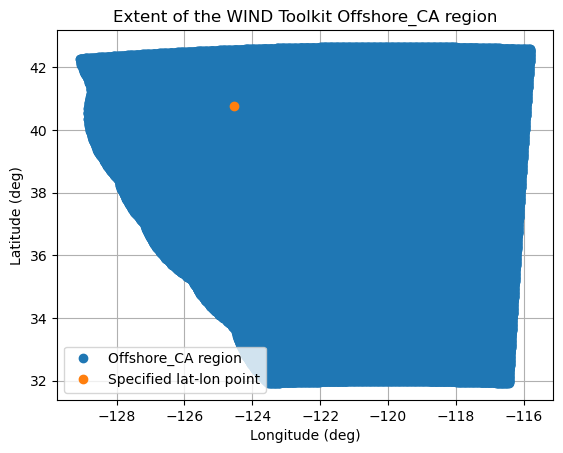

In [9]:
wind_toolkit.plot_region(requested_region, lat_lon=wtk_inputs["lat_lon"])

### Request data from the WIND Toolkit
To get the data we can use the `wind_toolkit.request_wtk_point_data` function with multiple parameters, locations and years. If multiple locations are input, they must correspond to the same hindcast region. If multiple parameters are input they must be available for the same time interval. 

This function will return the parameter data as a DataFrame which may be accessed by parameter name and index of the location. Here we only use the single location defined above, so the relevant DataFrame key is `'wind_speed_10m_0'`. 

In [10]:
wtk_wind, wtk_metadata = wind_toolkit.request_wtk_point_data(
    wtk_inputs["time_interval"],
    wtk_inputs["wind_parameters"],
    wtk_inputs["lat_lon"],
    wtk_inputs["year"],
)
wtk_wind

,windspeed_10m_0,winddirection_10m_0
time_index,,
2018-01-01 00:00:00+00:00,7.78,179.199997
2018-01-01 01:00:00+00:00,7.81,190.649994
2018-01-01 02:00:00+00:00,6.89,191.690002
2018-01-01 03:00:00+00:00,7.58,190.720001
2018-01-01 04:00:00+00:00,8.10,183.199997
...,...,...
2018-12-31 19:00:00+00:00,15.04,359.070007
2018-12-31 20:00:00+00:00,14.59,358.470001
2018-12-31 21:00:00+00:00,14.76,358.489990


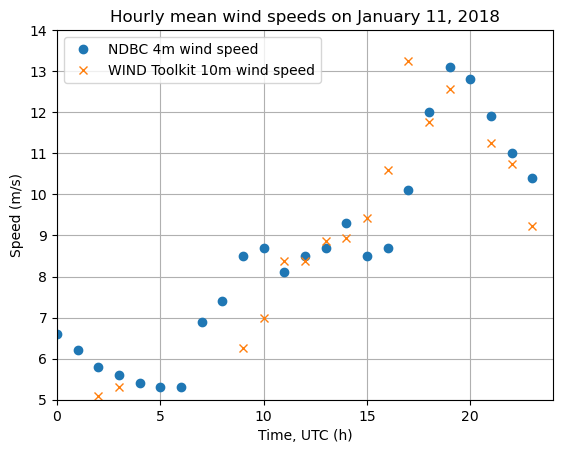

In [11]:
# Get WIND Toolkit and NDBC wind data for 2018-01-11
ndbc_hourly_data = ndbc_dict["2018"].loc["2018-01-11"].resample("h").nearest()
wtk_hourly_wind = wtk_wind.loc["2018-01-11"]

# Plot the timeseries
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time, UTC (h)")
ax.set_ylabel("Speed (m/s)")
ax.set_title("Hourly mean wind speeds on January 11, 2018")
ax.grid()
ax.set_ylim([5, 14])
ax.set_xlim([0, 24])
line1 = ax.plot(
    ndbc_hourly_data.index.hour,
    ndbc_hourly_data["WSPD"].values,
    "o",
    label="NDBC 4m wind speed",
)
line2 = ax.plot(
    wtk_hourly_wind.index.hour,
    wtk_hourly_wind["windspeed_10m_0"].values,
    "x",
    label="WIND Toolkit 10m wind speed",
)
ax.legend()

## 3. Compare NDBC and WIND Toolkit Data

Wind conditions may be characterized by the speed and direction over a day. A hourly time series of wind speed is a useful way of visualizing the diurnal variation on a give date. A wind rose can visualize variation in wind direction over the same period. Using the historical continuous wind data from NDBC and surface wind data from WIND Toolkit, we can calculate these variables in MHKiT. 

### Plot the hourly mean wind speeds on January 11, 2018
The NDBC data for January 11, 2018 is given in 10 minute intervals. We can get the instantaneous hourly wind data using the DataFrame `resample().nearest()` function. The WIND Toolkit data is already given as instantaneous hourly data. Then, we can plot the speeds vs the hour they occur. Some variation is seen due to difference in method and height.

### Create a mean wind speed wind rose for January 11, 2018
To complement the timeseries of wind speed, we can visualize the variation in wind direction over the day with a wind rose. The MHKiT `plot_rose` function will do this for us. Some variation is seen between NDBC and WIND Toolkit, possibly due to method and height. Users can further investigate different source of metocean data as desired.

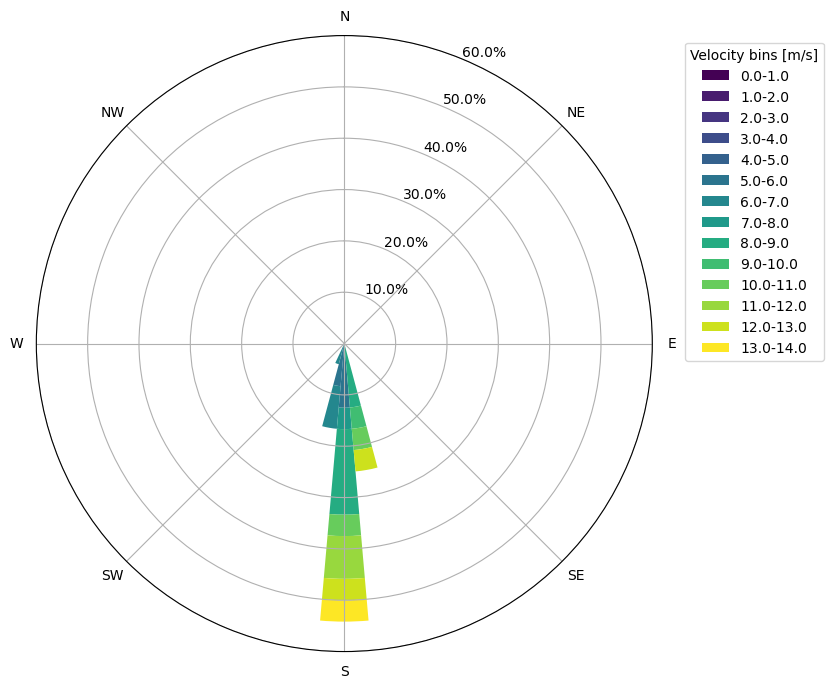

In [12]:
# Set the rose bin widths
width_direction = 10  # in degrees
width_velocity = 1  # in m/s

# Plot the wind rose
ax = plot_rose(
    ndbc_hourly_data["WDIR"], ndbc_hourly_data["WSPD"], width_direction, width_velocity
)

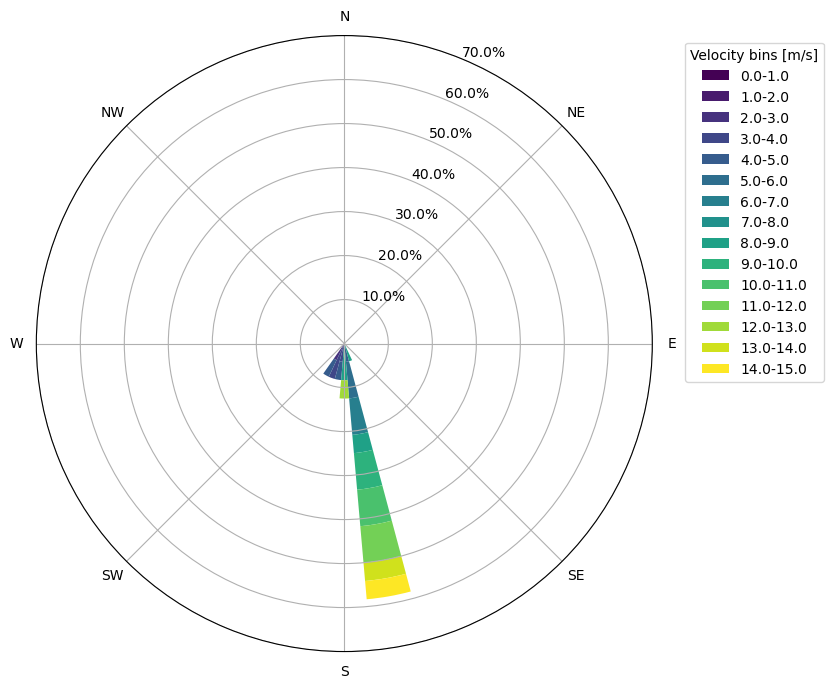

In [13]:
ax2 = plot_rose(
    wtk_hourly_wind["winddirection_10m_0"],
    wtk_hourly_wind["windspeed_10m_0"],
    width_direction,
    width_velocity,
)

### Plot vertical temperature profile
The air temperature at several vertical levels can be downloaded from the WIND Toolkit dataset. More or less vertical levels can be defined in the parameter input to `request_wtk_point_data` to increase resolution or decrease computation expense as desired. Note that times are given in UTC, can can optionally be converted to local time by finding the time zone of the chosen latitude/longitude pair. 

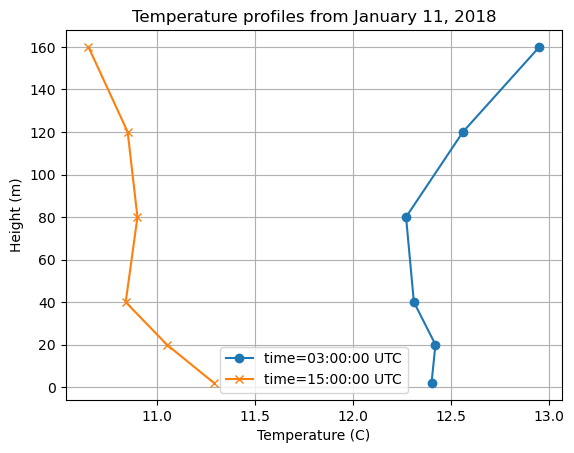

In [14]:
wtk_temp, wtk_metadata = wind_toolkit.request_wtk_point_data(
    wtk_inputs["time_interval"],
    wtk_inputs["temp_parameters"],
    wtk_inputs["lat_lon"],
    wtk_inputs["year"],
)
# wtk_temp = wtk_temp.shift(-7) # optionally UTC to local time

# Pick times corresponding to stable and unstable temperature profiles
stable_temp = wtk_temp.at_time("2018-01-11 03:00:00").values[0]
unstable_temp = wtk_temp.at_time("2018-01-11 15:00:00").values[0]

# Find heights from temperature DataFrame columns
heights = []
for s in wtk_temp.keys():
    s = s.removeprefix("temperature_")
    s = s.removesuffix("m_0")
    heights.append(float(s))
heights = np.array(heights)

# Plot the profiles
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Height (m)")
ax.set_title("Temperature profiles from January 11, 2018")
ax.grid()
line1 = ax.plot(stable_temp, heights, "o-", label="time=03:00:00 UTC")
line2 = ax.plot(unstable_temp, heights, "x-", label="time=15:00:00 UTC")
ax.legend()